In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=32,
                                         shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32,
                                         shuffle=False, num_workers=2)

In [ ]:
model = models.vgg16(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

num_ftrs = model.classifier[6].in_features 
model.classifier = model.classifier[:-1]

new_classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Linear(512, 10)
)

model.classifier = nn.Sequential(model.classifier, new_classifier) 

model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 68.4MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

In [ ]:
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # --- Validation Phase ---
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(valloader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

print('Finished Training')

Epoch 1, Train Loss: 1.3367, Train Acc: 53.28%, Val Loss: 1.1354, Val Acc: 60.04%
Epoch 2, Train Loss: 1.1878, Train Acc: 57.97%, Val Loss: 1.0846, Val Acc: 63.16%
Epoch 3, Train Loss: 1.1507, Train Acc: 59.20%, Val Loss: 1.0859, Val Acc: 62.26%
Epoch 4, Train Loss: 1.1166, Train Acc: 60.58%, Val Loss: 1.0517, Val Acc: 64.04%
Epoch 5, Train Loss: 1.0955, Train Acc: 61.37%, Val Loss: 1.0481, Val Acc: 63.96%
Epoch 6, Train Loss: 1.0757, Train Acc: 62.02%, Val Loss: 1.0331, Val Acc: 64.02%
Epoch 7, Train Loss: 1.0535, Train Acc: 62.59%, Val Loss: 1.0239, Val Acc: 64.70%
Epoch 8, Train Loss: 1.0415, Train Acc: 63.35%, Val Loss: 1.0258, Val Acc: 64.40%
Epoch 9, Train Loss: 1.0226, Train Acc: 63.56%, Val Loss: 1.0134, Val Acc: 64.68%
Epoch 10, Train Loss: 1.0059, Train Acc: 64.14%, Val Loss: 1.0203, Val Acc: 64.32%
Finished Training


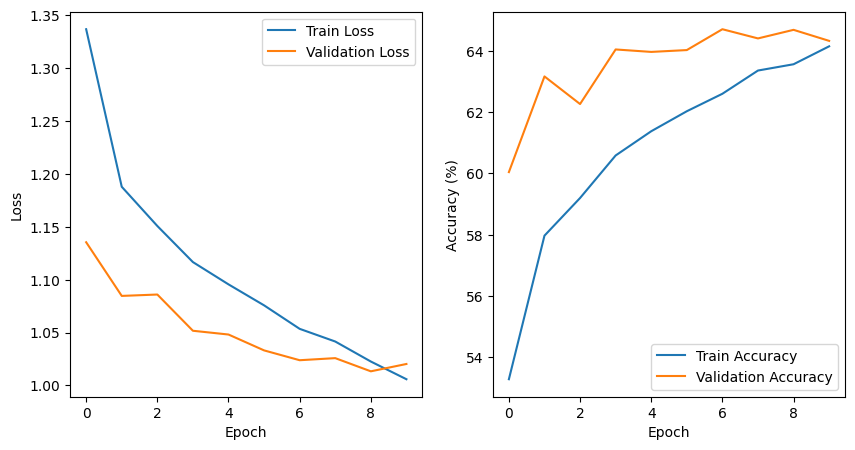

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 63.50%


In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters in the network: {num_params}')

Number of trainable parameters in the network: 2102794


در اینجا پارامتر را از خروجی فایل قبلی بدست آوردیم

In [ ]:
xception_num_params = 20861480 

print(f'Number of trainable parameters in VGG16 (after modification): {num_params}')
print(f'Number of trainable parameters in Xception (before modification): {xception_num_params}')

if num_params < xception_num_params:
    print("VGG16 has fewer trainable parameters than Xception (after our modifications).")
elif num_params > xception_num_params:
    print("VGG16 has more trainable parameters than Xception (after our modifications).")
else:
    print("VGG16 has the same number of trainable parameters as Xception (after our modifications).")

Number of trainable parameters in VGG16 (after modification): 2102794
Number of trainable parameters in Xception (before modification): 20861480
VGG16 has fewer trainable parameters than Xception (after our modifications).
